In [ ]:
#Latin hypercube
import numpy as np
from scipy.stats import qmc
import pandas as pd

# Define the boundaries for each variable
phosphate_bounds = (1, 20)    # Phosphate in µM
temperature_bounds = (4, 36)  # Temperature in °C

# Create a Latin Hypercube sampler for 2 dimensions
sampler = qmc.LatinHypercube(d=2)
n_samples = 5
sample = sampler.random(n=n_samples)

# Scale the sample to the desired continuous ranges:
l_bounds = [phosphate_bounds[0], temperature_bounds[0]]
u_bounds = [phosphate_bounds[1], temperature_bounds[1]]
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)

# Round the continuous values to the nearest integer
sample_int = np.rint(sample_scaled).astype(int)

print("5 Latin Hypercube integer sample points (phosphate, temperature):")
print(sample_int)
# Create a DataFrame from the hypercube sample (sample_int) with appropriate column names.
selected_conditions_df = pd.DataFrame(sample_int, columns=["Phosphate", "Temperature"])
#print("Hypercube-suggested conditions:")
#print(selected_conditions_df)

# Path to the DataCube.csv file
data_cube_file = r"DataCube.csv"

# Load the DataCube.csv file.
# Adjust the delimiter if needed (e.g., if your CSV uses semicolons instead of commas).
data_cube = pd.read_csv(data_cube_file, delimiter=";")
#print("\nLoaded DataCube.csv (first few rows):")
#print(data_cube.head())

# Ensure the key columns are of the same type (integers).
selected_conditions_df["Phosphate"] = selected_conditions_df["Phosphate"].astype(int)
selected_conditions_df["Temperature"] = selected_conditions_df["Temperature"].astype(int)

data_cube["Phosphate"] = data_cube["Phosphate"].astype(int)
data_cube["Temperature"] = data_cube["Temperature"].astype(int)

# Merge the hypercube conditions with the data from DataCube.csv.
# This will return only the rows from DataCube that match the selected conditions.
merged_results = pd.merge(selected_conditions_df, data_cube, on=["Phosphate", "Temperature"], how="left")

# Print the merged results.
#print("\nResults for hypercube-suggested conditions:")
#print(merged_results)

# Define the path to your CurrentResults.csv file
current_results_file = r"CurrentResults.csv"

# Append the merged results to CurrentResults.csv with semicolon as the separator.
# If the file exists, append without header; if not, create the file with headers.
if os.path.exists(current_results_file):
    merged_results.to_csv(current_results_file, mode='a', index=False, header=False, sep=";")
else:
    merged_results.to_csv(current_results_file, index=False, sep=";")

print("Merged results have been appended to CurrentResults.csv")


5 Latin Hypercube integer sample points (phosphate, temperature):
[[ 3 11]
 [11  4]
 [14 34]
 [20 30]
 [ 8 22]]
Merged results have been appended to CurrentResults.csv


Phosphate: 20.00 µM
Temperature: 16.03 °C
Predicted maximum growth rate: 1.79


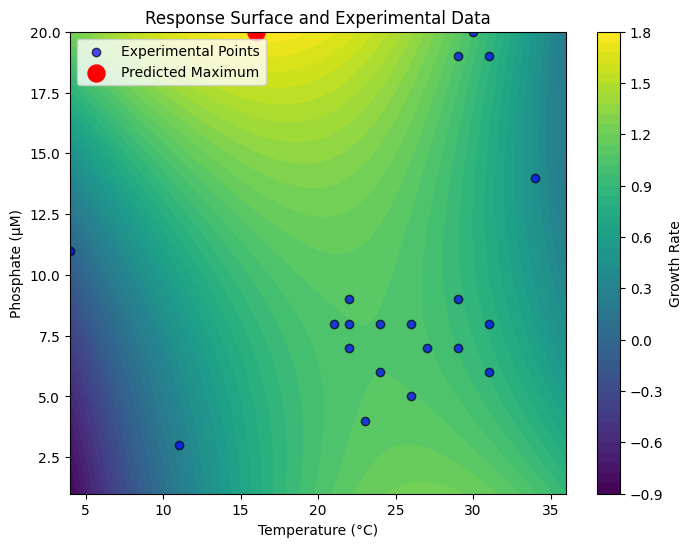

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import datetime
import os

# Load experimental results from the CSV file
file_path = r"CurrentResults.csv"
df = pd.read_csv(file_path, delimiter=";")
#print("Loaded experimental results:")
#print(df.head())

# The CSV file should have columns: "Phosphate", "Temperature", and "GrowthRate"

# Create additional columns for quadratic and interaction terms
df["Phosphate_sq"] = df["Phosphate"]**2
df["Temp_sq"] = df["Temperature"]**2
df["Phosphate_Temp"] = df["Phosphate"] * df["Temperature"]

# Fit a quadratic response surface model
model = smf.ols("GrowthRate ~ Phosphate + Temperature + Phosphate_sq + Temp_sq + Phosphate_Temp", data=df).fit()
#print("\nModel Summary:")
#print(model.summary())

# Define a prediction function using the fitted model parameters
def model_prediction(x, params):
    phosphate, temp = x
    return (params["Intercept"] +
            params["Phosphate"] * phosphate +
            params["Temperature"] * temp +
            params["Phosphate_sq"] * phosphate**2 +
            params["Temp_sq"] * temp**2 +
            params["Phosphate_Temp"] * phosphate * temp)

# Define the objective function (negative growth rate) for maximization
def objective(x, params):
    return -model_prediction(x, params)

# Define bounds for the factors: phosphate between 1 and 20 µM, temperature between 4 and 36 °C
bounds = [(1, 20), (4, 36)]
# Start from the center of the range
x0 = [(1 + 20) / 2, (4 + 36) / 2]

params = model.params

# Use optimization to find the maximum predicted growth rate within the bounds
result = minimize(objective, x0, args=(params,), bounds=bounds)
optimal_conditions = result.x
optimal_growth_rate = -result.fun

#print("\nOptimal conditions predicted by the model:")
print(f"Phosphate: {optimal_conditions[0]:.2f} µM")
print(f"Temperature: {optimal_conditions[1]:.2f} °C")
print(f"Predicted maximum growth rate: {optimal_growth_rate:.2f}")

# Swap axes: x-axis will be Temperature and y-axis will be Phosphate.
# Create grid accordingly:
temp_range = np.linspace(4, 36, 100)         # x-axis
phosphate_range = np.linspace(1, 20, 100)      # y-axis
T, P = np.meshgrid(temp_range, phosphate_range)  # T: horizontal, P: vertical

# Evaluate the response surface using the original model ordering (phosphate, then temperature)
Z = model_prediction(np.array([P, T]), params)

plt.figure(figsize=(8, 6))
# Note: contourf now uses T (Temperature) as x and P (Phosphate) as y
contour = plt.contourf(T, P, Z, levels=50, cmap="viridis")
plt.colorbar(contour, label="Growth Rate")
# Swap the scatter plot coordinates: x is Temperature, y is Phosphate
plt.scatter(df["Temperature"], df["Phosphate"], color='blue', label="Experimental Points", edgecolor='k', alpha=0.7)
# For the optimum, swap the coordinates: optimal_conditions[1] is Temperature, optimal_conditions[0] is Phosphate.
plt.scatter(optimal_conditions[1], optimal_conditions[0], color='red', marker='o', s=150, label="Predicted Maximum")
plt.xlabel("Temperature (°C)")
plt.ylabel("Phosphate (µM)")
plt.title("Response Surface and Experimental Data")
plt.legend()

# Define the directory where you want to save the file
save_directory = r"./"

# Create a timestamp string
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Construct the full file path
filename = f"Cycle-1_{timestamp}.png"
save_path = os.path.join(save_directory, filename)

plt.savefig(save_path, dpi=900, bbox_inches='tight')
plt.show()


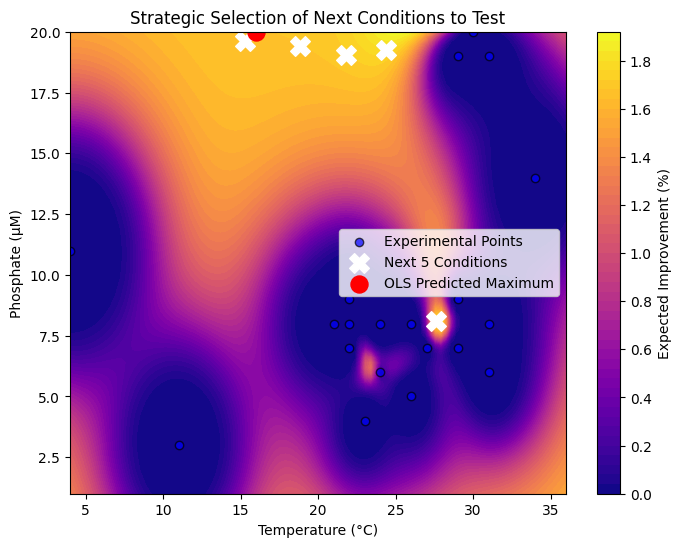


Suggested Next 5 Experimental Conditions (Rounded to Integers) with % Improvement:
1. Phosphate: 19 µM, Temperature: 19 °C, Expected Improvement: 1.7%
2. Phosphate: 19 µM, Temperature: 22 °C, Expected Improvement: 1.7%
3. Phosphate: 20 µM, Temperature: 15 °C, Expected Improvement: 1.7%
4. Phosphate: 8 µM, Temperature: 28 °C, Expected Improvement: 1.7%
5. Phosphate: 19 µM, Temperature: 24 °C, Expected Improvement: 1.8%
Merged results appended to CurrentResults.csv:
   Phosphate  Temperature  Specific Growth Rate per day
0         19           19                      0.838737
1         19           22                      1.179200
2         20           15                      0.660372
3          8           28                      1.206472
4         19           24                      1.087783


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

# 1. Load Experimental Data
file_path = r"CurrentResults.csv"
df = pd.read_csv(file_path, delimiter=";")

# Ensure the required columns exist
required_cols = {"Phosphate", "Temperature", "GrowthRate"}
if not required_cols.issubset(df.columns):
    raise ValueError("CSV file must contain columns: 'Phosphate', 'Temperature', and 'GrowthRate'")

# 2. Fit a Gaussian Process Model
# Use experimental data (Phosphate, Temperature) as features and GrowthRate as target.
X = df[["Phosphate", "Temperature"]].values
y = df["GrowthRate"].values
kernel = Matern(nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True)
gp.fit(X, y)

# Determine best observed value (for EI computation)
y_max = np.max(y)

# Create a candidate grid for prediction
phosphate_range = np.linspace(1, 20, 100)
temp_range = np.linspace(4, 36, 100)
#phosphate_range = np.linspace(df["Phosphate"].min(), df["Phosphate"].max(), 100)
#temp_range = np.linspace(df["Temperature"].min(), df["Temperature"].max(), 100)
P, T = np.meshgrid(phosphate_range, temp_range)  # P: Phosphate, T: Temperature
X_new = np.vstack([P.ravel(), T.ravel()]).T

# Predict on the candidate grid and determine the maximum predicted growth rate
y_pred_grid = gp.predict(X_new)
optimal_growth_rate = np.max(y_pred_grid)

# 3. Define the Expected Improvement (EI) Function
def expected_improvement(X_new, gp, y_max, xi=0.01):
    """Computes Expected Improvement (EI) at candidate points X_new."""
    mu, sigma = gp.predict(X_new, return_std=True)
    sigma = sigma.flatten()  # Ensure sigma is 1D for element-wise operations
    with np.errstate(divide='warn'):
        improvement = mu - y_max - xi
        Z = improvement / sigma
        ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0] = 0.0  # Avoid division by zero
    return ei

# Compute EI values on the candidate grid
ei_values = expected_improvement(X_new, gp, y_max)

# Convert the EI grid to percentages relative to the optimal predicted growth rate
EI_grid_pct = (ei_values.reshape(P.shape) / optimal_growth_rate) * 100

# 4. Select New Conditions via EI Clustering
# Identify the top candidate points based on EI.
num_candidates = 300  # Consider top 50 EI points
top_indices = np.argsort(ei_values)[-num_candidates:]
X_candidates = X_new[top_indices]

# Use K-Means clustering to pick 5 diverse candidate conditions.
num_experiments = 5
kmeans = KMeans(n_clusters=num_experiments, n_init=10, random_state=42)
kmeans.fit(X_candidates)
selected_indices = np.argmin(cdist(kmeans.cluster_centers_, X_candidates), axis=1)
selected_conditions = X_candidates[selected_indices]
selected_conditions_int = np.round(selected_conditions).astype(int)

# Also compute EI for each selected condition (in percentage)
selected_EI = expected_improvement(selected_conditions, gp, y_max)
selected_EI_percentage = (selected_EI / optimal_growth_rate) * 100

# 5. Plot the EI Heatmap with Swapped Axes
# Swap axes: x-axis will be Temperature, y-axis will be Phosphate.
plt.figure(figsize=(8, 6))
# Note: Our candidate grid was built with P for Phosphate and T for Temperature.
# To swap, we pass T as x and P as y.
contour = plt.contourf(T, P, EI_grid_pct, levels=50, cmap="plasma")
plt.colorbar(contour, label="Expected Improvement (%)")

# Overlay experimental data points (swapped coordinates: x = Temperature, y = Phosphate)
plt.scatter(df["Temperature"], df["Phosphate"], color='blue', label="Experimental Points", edgecolor='k', alpha=0.7)

# Overlay current optimum based on experimental data.
# Here we use the point with the highest observed growth rate.
#exp_opt_index = np.argmax(y)
#exp_optimum = X[exp_opt_index]  # [Phosphate, Temperature]
#plt.scatter(exp_optimum[1], exp_optimum[0], color='red', marker='o', s=150, label="EI Predicted Optimum")

# Overlay the new suggested conditions (swapped: x = Temperature, y = Phosphate)
plt.scatter(selected_conditions[:, 1], selected_conditions[:, 0], color='white', marker='X', s=200, label="Next 5 Conditions")
plt.xlabel("Temperature (°C)")
plt.ylabel("Phosphate (µM)")
plt.title("Strategic Selection of Next Conditions to Test")
plt.legend()
# Overlay the OLS-predicted optimum (Phosphate, Temperature)
# Because the EI plot is swapped, we pass x=Temperature, y=Phosphate:
plt.scatter(
    optimal_conditions[1],  # Temperature
    optimal_conditions[0],  # Phosphate
    color='red',
    marker='o',
    s=150,
    label="OLS Predicted Maximum"
)
plt.legend()

# Define the directory where you want to save the file
save_directory = r"./"

# Create a timestamp string
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Construct the full file path
filename = f"Expected+Kmeans_{timestamp}.png"
save_path = os.path.join(save_directory, filename)

plt.savefig(save_path, dpi=900, bbox_inches='tight')
plt.show()

# 6. Print the Suggested Next 5 Conditions with % Expected Improvement
print("\nSuggested Next 5 Experimental Conditions (Rounded to Integers) with % Improvement:")
for i, (condition, rel_EI) in enumerate(zip(selected_conditions_int, selected_EI_percentage)):
    phosphate, temperature = condition  # condition: [Phosphate, Temperature]
    print(f"{i+1}. Phosphate: {phosphate} µM, Temperature: {temperature} °C, Expected Improvement: {rel_EI:.1f}%")
# 1. Define file paths
data_cube_file = r"DataCube.csv"
current_results_file = r"CurrentResults.csv"

# 2. Load the DataCube
data_cube = pd.read_csv(data_cube_file, delimiter=";")

# 3. Convert selected_conditions_int to a DataFrame
#    selected_conditions_int should be a NumPy array of shape (5, 2).
selected_conditions_df = pd.DataFrame(selected_conditions_int, columns=["Phosphate", "Temperature"])

# 4. Ensure consistent data types for merging
selected_conditions_df["Phosphate"] = selected_conditions_df["Phosphate"].astype(int)
selected_conditions_df["Temperature"] = selected_conditions_df["Temperature"].astype(int)
data_cube["Phosphate"] = data_cube["Phosphate"].astype(int)
data_cube["Temperature"] = data_cube["Temperature"].astype(int)

# 5. Merge the 5 new conditions with the DataCube to retrieve GrowthRate
merged_results = pd.merge(selected_conditions_df, data_cube, on=["Phosphate", "Temperature"], how="left")

# 6. Append merged results to CurrentResults.csv
#    If the file exists, append without header; if not, create with headers.
if os.path.exists(current_results_file):
    merged_results.to_csv(current_results_file, mode='a', index=False, header=False, sep=";")
else:
    merged_results.to_csv(current_results_file, index=False, sep=";")

print("Merged results appended to CurrentResults.csv:")
print(merged_results)